<a href="https://colab.research.google.com/github/CristhianCastro96/BITrepository/blob/main/Act_VII_Data_Wranglin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importo las librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


In [3]:
# Cargo el dataset
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('Urban Air Quality and Health Impact Dataset.csv')

# Visualizo las primeras filas
dataset.head()


Saving Urban Air Quality and Health Impact Dataset.csv to Urban Air Quality and Health Impact Dataset (1).csv


,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,City,Temp_Range,Heat_Index,Severity_Score,Condition_Code,Month,Season,Day_of_Week,Is_Weekend,Health_Risk_Score
0,2024-09-07,1.725692e+09,106.1,91.0,98.5,104.0,88.1,95.9,51.5,21.0,...,Phoenix,15.1,95.918703,4.4300,NaN,9.0,Fall,Saturday,True,10.522170
1,2024-09-08,1.725779e+09,103.9,87.0,95.4,100.5,84.7,92.3,48.7,21.5,...,Phoenix,16.9,92.281316,3.8800,0.0,9.0,Fall,Sunday,True,10.062332
2,2024-09-09,1.725865e+09,105.0,83.9,94.7,99.9,81.6,90.6,41.7,16.9,...,Phoenix,21.1,90.599165,3.6300,0.0,9.0,Fall,Monday,False,9.673387
3,2024-09-10,1.725952e+09,106.1,81.2,93.9,100.6,79.5,89.8,39.1,15.7,...,Phoenix,24.9,89.638811,2.8512,0.0,9.0,Fall,Tuesday,False,9.411519
4,2024-09-11,1.726038e+09,106.1,82.1,94.0,101.0,80.0,90.0,40.1,15.9,...,Phoenix,24.0,89.760414,3.3908,0.0,9.0,Fall,Wednesday,False,9.515179


In [6]:
# Verifico valores nulos
print(dataset.isnull().sum())

# Imputación para columnas numéricas usando KNN
imputer = KNNImputer(n_neighbors=5)
num_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
dataset[num_cols] = imputer.fit_transform(dataset[num_cols])

# Imputación para columnas categóricas con "Desconocido"
cat_cols = dataset.select_dtypes(include=['object']).columns
for col in cat_cols:
    dataset[col] = dataset[col].fillna('Desconocido')

# Verifico nuevamente los valores nulos después de la imputación
print(dataset.isnull().sum())



datetime             0
datetimeEpoch        0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
preciptype           0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
pressure             0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
uvindex              0
severerisk           0
sunrise              0
sunriseEpoch         0
sunset               0
sunsetEpoch          0
moonphase            0
conditions           0
description          0
icon                 0
stations             0
source               0
City                 0
Temp_Range           0
Heat_Index           0
Severity_Score       0
Condition_Code       0
Month                0
Season               0
Day_of_Week

In [7]:
# Elimino duplicados basados en columnas relevantes como 'DateTime' y 'City'
dataset.drop_duplicates(subset=['datetime', 'City'], inplace=True)

# Confirmo la eliminación de duplicados
print(f"Número de duplicados restantes: {dataset.duplicated().sum()}")


Número de duplicados restantes: 0


In [8]:
# Defino una función para identificar outliers usando IQR
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Identifico outliers en la columna 'tempmax' como ejemplo
outliers_tempmax = detect_outliers_iqr(dataset, 'tempmax')
print(f"Número de outliers en tempmax: {len(outliers_tempmax)}")


Número de outliers en tempmax: 0


In [9]:
from scipy import stats

# Defino una función para identificar outliers usando Z-Score
def detect_outliers_zscore(df, col):
    z_scores = stats.zscore(df[col])
    return df[(z_scores > 3) | (z_scores < -3)]

# Identificar outliers en la columna 'tempmax' como ejemplo
outliers_tempmax_z = detect_outliers_zscore(dataset, 'tempmax')
print(f"Número de outliers en tempmax (Z-Score): {len(outliers_tempmax_z)}")


Número de outliers en tempmax (Z-Score): 0


In [10]:
# Elimino outliers usando el método IQR
dataset_no_outliers = dataset[~dataset.index.isin(outliers_tempmax.index)]

# Verifico el nuevo tamaño del dataset
print(f"Tamaño del dataset después de eliminar outliers: {dataset_no_outliers.shape}")


Tamaño del dataset después de eliminar outliers: (150, 46)


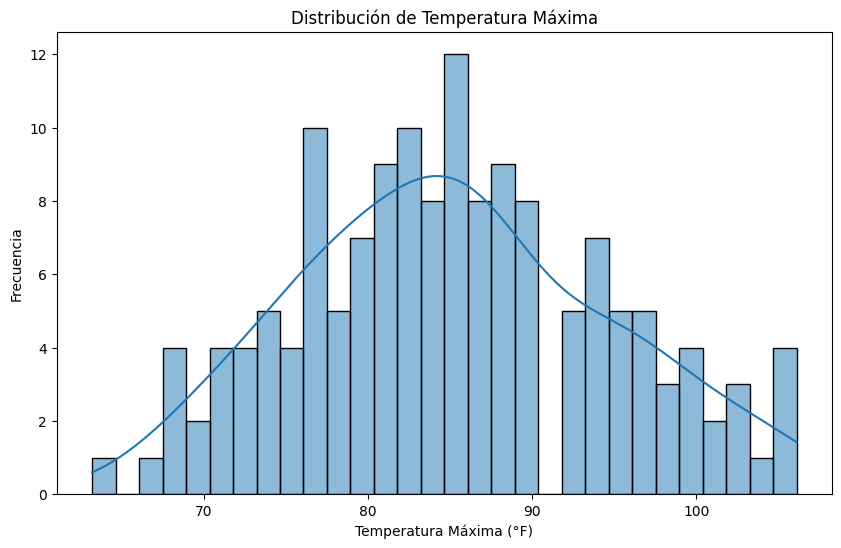

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafico la distribución de la temperatura máxima
plt.figure(figsize=(10, 6))
sns.histplot(dataset_no_outliers['tempmax'], bins=30, kde=True)
plt.title('Distribución de Temperatura Máxima')
plt.xlabel('Temperatura Máxima (°F)')
plt.ylabel('Frecuencia')
plt.show()


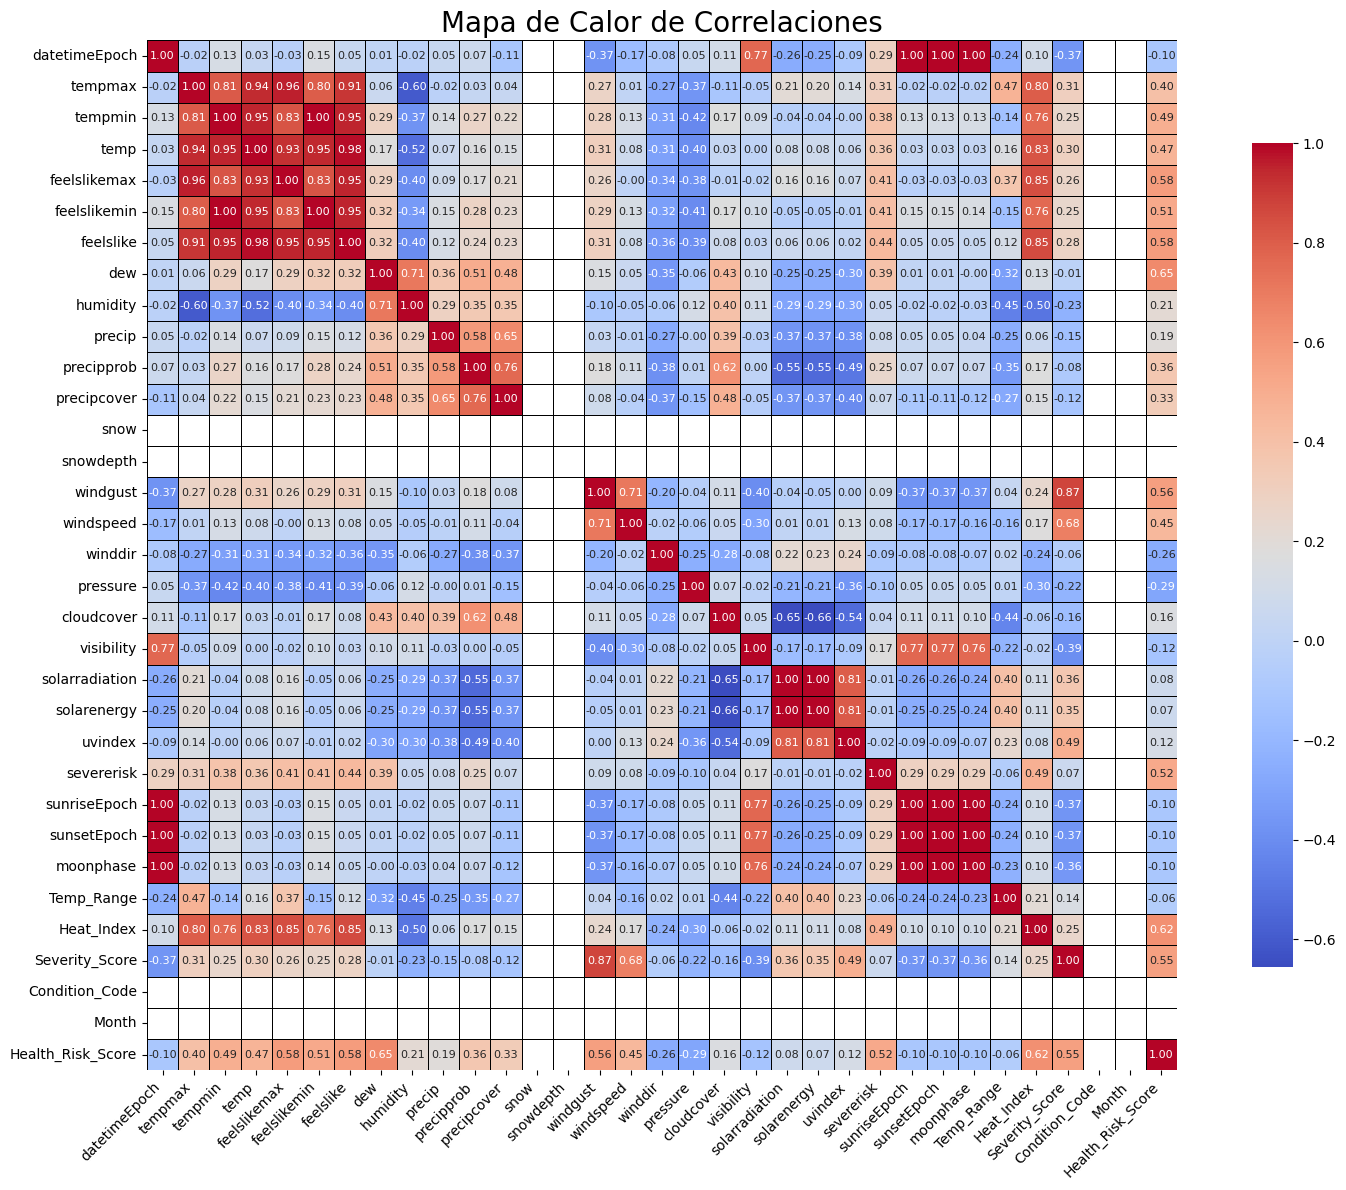

In [15]:
# Filtro solo las columnas numéricas
numeric_columns = dataset_no_outliers.select_dtypes(include='number')

# Calculo la matriz de correlación solo con columnas numéricas
correlation_matrix = numeric_columns.corr()

# Grafico el mapa de calor de correlación con números más pequeños
plt.figure(figsize=(16, 12))  # Aumentar el tamaño del gráfico
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            square=True,
            cbar_kws={"shrink": .8},  # Ajustar la barra de color
            linewidths=.5,  # Líneas entre las celdas
            linecolor='black',  # Color de las líneas entre las celdas
            annot_kws={"size": 8})  # Tamaño de fuente de las anotaciones

# Roto etiquetas de los ejes
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de Calor de Correlaciones', fontsize=20)
plt.tight_layout()  # Ajusto el diseño para que no se corte el texto
plt.show()



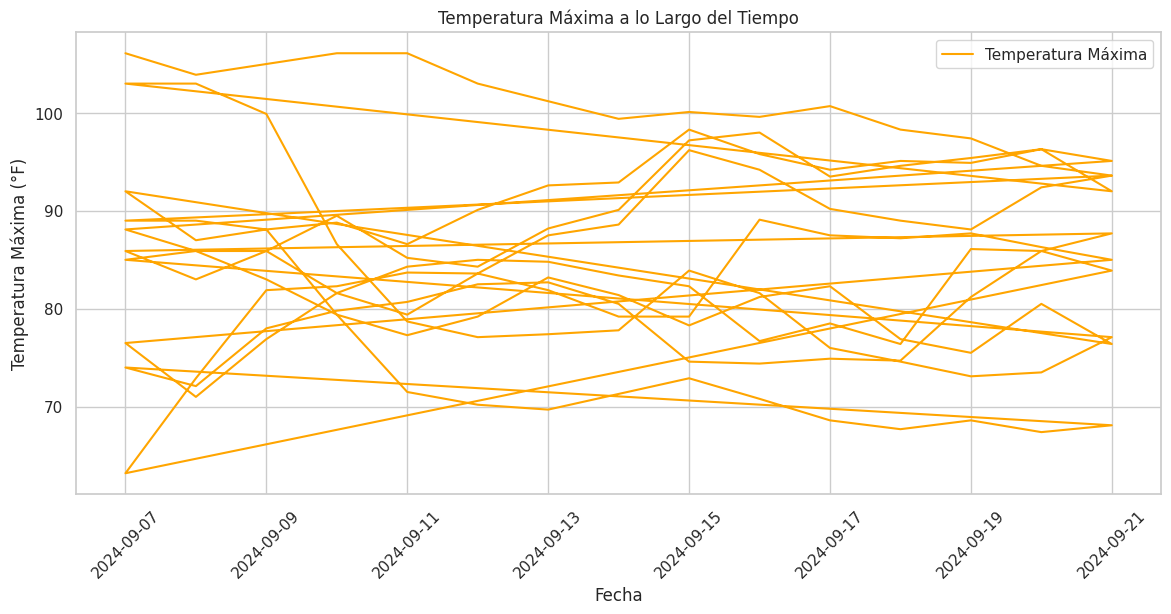

In [17]:
# Me asegúro de que la columna 'datetime' sea del tipo datetime
dataset_no_outliers['datetime'] = pd.to_datetime(dataset_no_outliers['datetime'])

# Grafico la temperatura máxima a lo largo del tiempo
plt.figure(figsize=(14, 6))
plt.plot(dataset_no_outliers['datetime'], dataset_no_outliers['tempmax'], label='Temperatura Máxima', color='orange')
plt.title('Temperatura Máxima a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (°F)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [18]:
# Convierto variables categóricas a variables dummy
dataset_final = pd.get_dummies(dataset_no_outliers, columns=['City', 'preciptype', 'conditions'], drop_first=True)


In [19]:
from sklearn.model_selection import train_test_split

# Defino características (X) y la variable objetivo (y)
X = dataset_final.drop('Health_Risk_Score', axis=1)
y = dataset_final['Health_Risk_Score']

# Divido en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que 'time_column' es el nombre de la columna de tiempo
# Convierto la columna de tiempo a segundos
def time_to_seconds(time_str):
    if isinstance(time_str, str):
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    return 0

# Aplico la conversión a tu columna de tiempo
# Reemplazo 'time_column' con el nombre real de tu columna
if 'time_column' in X_train.columns:
    X_train['time_column'] = X_train['time_column'].apply(time_to_seconds)
    X_test['time_column'] = X_test['time_column'].apply(time_to_seconds)

# X_train y X_test solo contengan columnas numéricas
X_train = X_train.select_dtypes(exclude=['datetime64[ns]', 'object'])
X_test = X_test.select_dtypes(exclude=['datetime64[ns]', 'object'])

# Entreno un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hago predicciones
y_pred = model.predict(X_test)

# Evaluo el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.006642934276268952
R^2 Score: 0.9858791820495418


Mean Squared Error (MSE): Un valor bajo de MSE (0.0066) indica que las predicciones del modelo están bastante cerca de los valores reales. En el contexto del problema, esto significa que el modelo está haciendo un buen trabajo en predecir los valores.

R² Score: Un valor de R² de aproximadamente 0.986 indica que el modelo explica alrededor del 98.6% de la variabilidad en los datos de salida. Esto es un indicativo de que el modelo es bastante efectivo y que tiene un alto grado de ajuste.

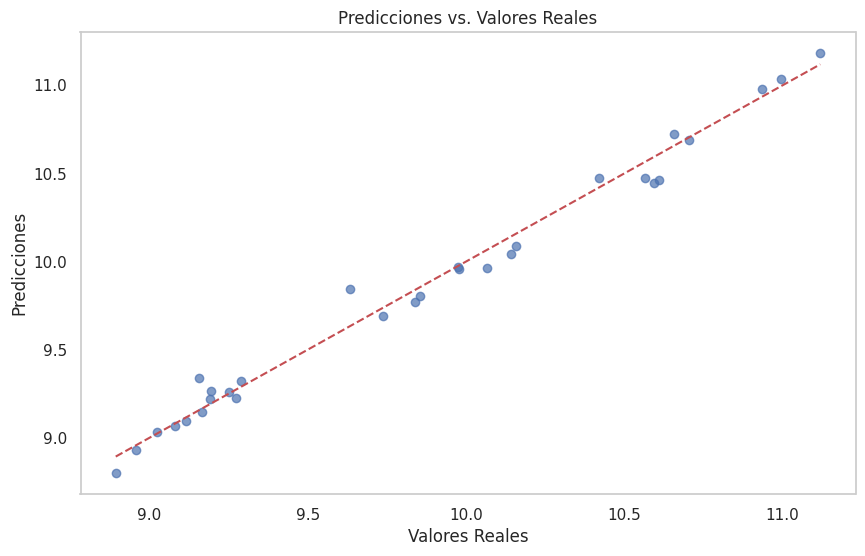

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de referencia
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.grid()
plt.show()


In [24]:
import joblib
joblib.dump(model, 'regression_model.pkl')


['regression_model.pkl']